In [1]:
!pip install torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 868.8/868.8 kB 18.5 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-

In [2]:
!pip install peft

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 251.6/251.6 kB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.6/302.6 kB 30.0 MB/s eta 0:00:00


### 0. 라이브러리

In [3]:
# 라이브러리
import warnings
warnings.filterwarnings('ignore')

import os
import time
import pickle
import random

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchmetrics.classification import BinaryF1Score, BinaryAccuracy
from torchsummary import summary

import transformers
from transformers import AutoTokenizer, AutoModelForSequenceClassification

from peft import get_peft_model, LoraConfig, TaskType

In [4]:
# OS 충돌 방지
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

# Matplotlib 커널 종료 방지
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [5]:
# 시드 고정
def fixSEED(seed, deterministic=True):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    if deterministic:
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

fixSEED(seed=42)

In [6]:
# 디렉토리 설정
dir = 'Model'
path = '/content/drive/MyDrive/Projects/' + dir
os.chdir(path)
print(path)

/content/drive/MyDrive/Projects/Model


In [7]:
# GPU 사용 여부 확인
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


### 1. 데이터 불러오기 및 가공

In [8]:
# Load data from a pickle file, and create labels
def callData(path: str):
    with open(path, "rb" ) as file:
        data = pickle.load(file)

    zero = data[data['label']==0]
    non_zero = data[data['label']==1]

    print(f'레이블 0 개수 : {len(zero)}')
    print(f'레이블 1 개수 : {len(non_zero)}')

    return data

In [9]:
# load data
data = callData("YouTube_Total.pkl")

레이블 0 개수 : 2750
레이블 1 개수 : 2066


In [10]:
# check
data.head()

,youtuber,channel_id,title,video_id,thumbnail,content,label,text
0,스토리 온,UCnB32ivbQAd6p-4sfM07wfA,뉴스특보! 5월29일,5YyM7kwoNew,https://i.ytimg.com/vi/5YyM7kwoNew/hqdefault.jpg,최근 중국의 한 방송에서는 한국산 장갑차에 대해 심도 깊게 분석하는 프로그램을 내보...,1,뉴스특보! 5월29일 최근 중국의 한 방송에서는 한국산 장갑차에 대해 심도 깊게 분...
1,스토리 온,UCnB32ivbQAd6p-4sfM07wfA,"中""한국이 금지무기 사용 계획하고 있다"" 美 싱크탱크 ""한국 대만 동시 방어 불가능...",Fys1gAjgBVM,https://i.ytimg.com/vi/Fys1gAjgBVM/hqdefault.jpg,최근 연일 논쟁을 일으키고 있는 트럼프의 돌발 발언 주한미군 존치 문제를 불판 위에...,1,"中""한국이 금지무기 사용 계획하고 있다"" 美 싱크탱크 ""한국 대만 동시 방어 불가능..."
2,스토리 온,UCnB32ivbQAd6p-4sfM07wfA,"형제국조차 배신한 일본, 북한과 접촉해 곤욕!! ""북한과의 비밀 거래로 AUKUS...",qrgVNVXUaJM,https://i.ytimg.com/vi/qrgVNVXUaJM/hqdefault.jpg,최근 일본이 크게 망신을 당한 일이 있었습니다 요즘 들어 대만을 중심으로 점점 중국...,1,"형제국조차 배신한 일본, 북한과 접촉해 곤욕!! ""북한과의 비밀 거래로 AUKUS..."
3,스토리 온,UCnB32ivbQAd6p-4sfM07wfA,뭐!!쏴보라며 영해 침범한 중국선박이 침몰했다 무기 총출동 맹폭에 중국 해군 ‘혼비...,wYIIkBPgZpw,https://i.ytimg.com/vi/wYIIkBPgZpw/hqdefault.jpg,필리핀이 중국에게 결국이를 저질렀습니다 중국이 불편한 기색을 드러냈음에도 불구하고 ...,1,뭐!!쏴보라며 영해 침범한 중국선박이 침몰했다 무기 총출동 맹폭에 중국 해군 ‘혼비...
4,스토리 온,UCnB32ivbQAd6p-4sfM07wfA,"루마니아,""무기 구매에 차관 필요 없다"" 10조 원 화끈하게 지른 천적 없는 최강...",T-E8DyerS64,https://i.ytimg.com/vi/T-E8DyerS64/hqdefault.jpg,재작년부터 높은 성과를 이어오고 있는 한국방산 그런 한국 방산이 최근 들어 가장 심...,1,"루마니아,""무기 구매에 차관 필요 없다"" 10조 원 화끈하게 지른 천적 없는 최강..."


### 2. Train/Valid/Test

In [11]:
# Split into Train/Valid/Test
def splitData(data, SEED=42):
    train_val_data, test_data = train_test_split(data, test_size=0.2, random_state=SEED)
    train_data, valid_data = train_test_split(train_val_data, test_size=0.25, random_state=SEED)

    print('학습용 데이터 개수 : {}개 \n검증용 데이터 개수 : {}개 \n평가용 데이터 개수 : {}개'.format(len(train_data), len(valid_data), len(test_data)))
    del train_val_data
    return train_data, valid_data, test_data

In [12]:
train_data, valid_data, test_data = splitData(data)

학습용 데이터 개수 : 2889개 
검증용 데이터 개수 : 963개 
평가용 데이터 개수 : 964개


### 3. Dataset 및 Dataloader 정의

In [13]:
# 파라미터 개수 확인
def print_trainable_parameters(model):
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(f"Trainable Params: {trainable_params} \nAll params: {all_param}")
    print('-'*50)
    print(f"Trainable(%): {round(100 * trainable_params / all_param, 5)}")

In [14]:
# One-way BERT Dataset
class OwoWayBERTDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_length=128):
        self.data = dataframe
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        text = self.data.iloc[idx]['text'] # 제목 + 자막
        label = self.data.iloc[idx]['label']

        inputs = self.tokenizer(text, return_tensors='pt', padding='max_length', truncation=True, max_length=self.max_length)

        input_ids = inputs['input_ids'].squeeze(0)
        attention_mask = inputs['attention_mask'].squeeze(0)

        return input_ids, attention_mask, torch.tensor(label, dtype=torch.long) # 정수형

### 4. 모델 정의

In [15]:
class OneWayBERTwithYouTube(nn.Module):
    def __init__(self, model_checkpoint, lora_r=8, lora_alpha=1, lora_dropout=0.1):
        super(OneWayBERTwithYouTube, self).__init__()

        # Pre-trained Model
        self.model = AutoModelForSequenceClassification.from_pretrained(model_checkpoint, num_labels=2)

        # LoRA Config
        lora_config = LoraConfig(
            task_type=TaskType.SEQ_CLS,
            target_modules=["query", "value"],  # Apply LoRA to the attention layers
            r=lora_r,
            lora_alpha=lora_alpha,
            lora_dropout=lora_dropout
        )

        # Apply LoRA to Pre-trained Layers
        self.model = get_peft_model(self.model, lora_config)

    def forward(self, input_ids, attention_mask):
        outputs = self.model(input_ids=input_ids, attention_mask=attention_mask).logits
        return outputs

### 5. 학습용 Trainer 정의

In [17]:
class Trainer:
    def __init__(self, model, train_dataloader, valid_dataloader, criterion, optimizer, acc_metric, f1_metric, device, num_epochs, wait_for_es):
        self.model = model  # model for training
        self.train_dataloader = train_dataloader  # training dataloader
        self.valid_dataloader = valid_dataloader  # validation dataloader
        self.criterion = criterion  # loss function
        self.optimizer = optimizer  # optimizer
        self.acc_metric = acc_metric  # accuracy metric
        self.f1_metric = f1_metric  # f1 score metric
        self.device = device  # device(cuda or cpu)
        self.num_epochs = num_epochs  # number of epochs
        self.wait_for_es = wait_for_es  # early stopping patience

    def train(self):
        train_loss_history, train_acc_history, train_f1_history = [], [], []
        valid_loss_history, valid_acc_history, valid_f1_history = [], [], []

        best_loss = float('inf')
        count = 0
        best_acc = 0
        start_time = time.time()

        for epoch in range(self.num_epochs):
            print('-' * 80)
            print(f'Epoch {epoch+1}/{self.num_epochs}')
            print('-' * 80)

            train_loss, train_acc, train_f1 = self._train_model()
            valid_loss, valid_acc, valid_f1 = self._valid_model()

            train_loss_history.append(train_loss)
            train_acc_history.append(train_acc)
            train_f1_history.append(train_f1)

            valid_loss_history.append(valid_loss)
            valid_acc_history.append(valid_acc)
            valid_f1_history.append(valid_f1)

            elapsed_time = time.time() - start_time
            print(f'[Train] \t Loss: {train_loss:.4f} \t Acc: {train_acc:.4f} \t F1: {train_f1:.4f}')
            print(f'[Valid] \t Loss: {valid_loss:.4f} \t Acc: {valid_acc:.4f} \t F1: {valid_f1:.4f}')
            print(f'(Epoch {epoch+1} complete in {elapsed_time // 60:.0f}m {elapsed_time % 60:.0f}s)')

            if valid_acc > best_acc:
                best_acc = valid_acc
                try:
                    torch.save(self.model.state_dict(), f'./models/Youtube/RoBERTaWithYouTube(Total)_ACC_{valid_acc:.4f}.pth')
                except:
                    print('Model Not Saved')
                    continue

            if valid_loss < best_loss:
                best_loss = valid_loss
                count = 0
            else:
                count += 1
                if count >= self.wait_for_es:
                    print(f'Early Stopping at Epoch {epoch+1}')
                    break

        return train_loss_history, train_acc_history, train_f1_history, valid_loss_history, valid_acc_history, valid_f1_history

    # Training function
    def _train_model(self):
        self.model.train()

        train_loss = 0
        train_acc = 0
        train_f1 = 0

        for batch in tqdm(self.train_dataloader, desc='Training'):
            input_ids, attention_mask, y = batch
            input_ids, attention_mask, y = input_ids.to(self.device), attention_mask.to(self.device), y.to(self.device)

            outputs = self.model(input_ids, attention_mask)
            loss = self.criterion(outputs, y) # 데이터셋에서 레이블을 long으로 정의함

            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()

            preds = torch.argmax(outputs, dim=1)
            train_loss += loss.item()
            train_acc += self.acc_metric(preds, y).item()
            train_f1 += self.f1_metric(preds, y).item()

        return train_loss / len(self.train_dataloader), train_acc / len(self.train_dataloader), train_f1 / len(self.train_dataloader)

    # Validating function
    def _valid_model(self):
        self.model.eval()

        valid_loss = 0
        valid_acc = 0
        valid_f1 = 0

        with torch.no_grad():
            for batch in tqdm(self.valid_dataloader, desc='Validating'):
                input_ids, attention_mask, y = batch
                input_ids, attention_mask, y = input_ids.to(self.device), attention_mask.to(self.device), y.to(self.device)

                outputs = self.model(input_ids, attention_mask)
                loss = self.criterion(outputs, y.long())

                preds = torch.argmax(outputs, dim=1)
                valid_loss += loss.item()
                valid_acc += self.acc_metric(preds, y).item()
                valid_f1 += self.f1_metric(preds, y).item()

        return valid_loss / len(self.valid_dataloader), valid_acc / len(self.valid_dataloader), valid_f1 / len(self.valid_dataloader)

### 6. 학습 진행

In [18]:
# 데이터셋 파라미터
batch_size = 32
num_labels = 2
max_length = 128

model_checkpoint = "klue/roberta-large"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

tokenizer_config.json:   0%|          | 0.00/375 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/248k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/752k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/173 [00:00<?, ?B/s]

In [19]:
# 데이터셋 정의
train_dataset = OwoWayBERTDataset(train_data, tokenizer, max_length = max_length)
valid_dataset = OwoWayBERTDataset(valid_data, tokenizer, max_length = max_length)
test_dataset = OwoWayBERTDataset(test_data, tokenizer, max_length = max_length)

In [20]:
# 데이터로더 정의
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

next(iter(train_dataloader))

[tensor([[    0,  3693,  2069,  ..., 14275,  2205,     2],
         [    0,   116,  1771,  ...,  2227,  2129,     2],
         [    0,   801,  2116,  ...,  2062,  1039,     2],
         ...,
         [    0,  6573,  2158,  ...,  2318,  1891,     2],
         [    0,   220,   116,  ...,  2178,  2062,     2],
         [    0, 19569,  2052,  ...,  2069,  9154,     2]]),
 tensor([[1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1],
         ...,
         [1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1]]),
 tensor([1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0,
         0, 0, 1, 1, 1, 1, 1, 0])]

In [21]:
# Model
model = OneWayBERTwithYouTube(model_checkpoint)
model.to(device)

config.json:   0%|          | 0.00/547 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.35G [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at klue/roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


OneWayBERTwithYouTube(
  (model): PeftModelForSequenceClassification(
    (base_model): LoraModel(
      (model): RobertaForSequenceClassification(
        (roberta): RobertaModel(
          (embeddings): RobertaEmbeddings(
            (word_embeddings): Embedding(32000, 1024, padding_idx=1)
            (position_embeddings): Embedding(514, 1024, padding_idx=1)
            (token_type_embeddings): Embedding(1, 1024)
            (LayerNorm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (encoder): RobertaEncoder(
            (layer): ModuleList(
              (0-23): 24 x RobertaLayer(
                (attention): RobertaAttention(
                  (self): RobertaSelfAttention(
                    (query): lora.Linear(
                      (base_layer): Linear(in_features=1024, out_features=1024, bias=True)
                      (lora_dropout): ModuleDict(
                        (default): Dropout(p=0

In [22]:
# LoRA 적용 후 훈련 가능한 파라미터 개수
print_trainable_parameters(model)

Trainable Params: 1838082 
All params: 338496516
--------------------------------------------------
Trainable(%): 0.54301


In [23]:
# 손실함수와 옵티마이저, 그리고 Metrics
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-5)
acc_metric = BinaryAccuracy().to(device)
f1_metric = BinaryF1Score().to(device)

In [24]:
# 모델 학습 파라미터
num_epochs = 15
wait_for_es = 5

In [25]:
# Trainer 정의
trainer = Trainer(model,
                  train_dataloader,
                  valid_dataloader,
                  criterion,
                  optimizer,
                  acc_metric,
                  f1_metric,
                  device,
                  num_epochs,
                  wait_for_es)

In [26]:
# 학습 시작
train_loss_history, train_acc_history, train_f1_history, valid_loss_history, valid_acc_history, valid_f1_history = trainer.train()

--------------------------------------------------------------------------------
Epoch 1/15
--------------------------------------------------------------------------------


Validating: 100%|██████████| 31/31 [00:17<00:00,  1.82it/s]


[Train] 	 Loss: 0.6568 	 Acc: 0.5941 	 F1: 0.2402
[Valid] 	 Loss: 0.6175 	 Acc: 0.6929 	 F1: 0.4095
(Epoch 1 complete in 1m 41s)
--------------------------------------------------------------------------------
Epoch 2/15
--------------------------------------------------------------------------------


Validating: 100%|██████████| 31/31 [00:17<00:00,  1.81it/s]


[Train] 	 Loss: 0.5991 	 Acc: 0.7167 	 F1: 0.5127
[Valid] 	 Loss: 0.5706 	 Acc: 0.8118 	 F1: 0.7124
(Epoch 2 complete in 3m 27s)
--------------------------------------------------------------------------------
Epoch 3/15
--------------------------------------------------------------------------------


Validating: 100%|██████████| 31/31 [00:17<00:00,  1.82it/s]


[Train] 	 Loss: 0.5513 	 Acc: 0.8094 	 F1: 0.7366
[Valid] 	 Loss: 0.5233 	 Acc: 0.8206 	 F1: 0.7195
(Epoch 3 complete in 5m 11s)
--------------------------------------------------------------------------------
Epoch 4/15
--------------------------------------------------------------------------------


Validating: 100%|██████████| 31/31 [00:17<00:00,  1.82it/s]


[Train] 	 Loss: 0.5101 	 Acc: 0.8420 	 F1: 0.7951
[Valid] 	 Loss: 0.4799 	 Acc: 0.8528 	 F1: 0.7633
(Epoch 4 complete in 6m 56s)
--------------------------------------------------------------------------------
Epoch 5/15
--------------------------------------------------------------------------------


Validating: 100%|██████████| 31/31 [00:17<00:00,  1.82it/s]


[Train] 	 Loss: 0.4620 	 Acc: 0.8649 	 F1: 0.8265
[Valid] 	 Loss: 0.4438 	 Acc: 0.8632 	 F1: 0.8240
(Epoch 5 complete in 8m 41s)
--------------------------------------------------------------------------------
Epoch 6/15
--------------------------------------------------------------------------------


Validating: 100%|██████████| 31/31 [00:17<00:00,  1.81it/s]


[Train] 	 Loss: 0.4182 	 Acc: 0.8808 	 F1: 0.8474
[Valid] 	 Loss: 0.3995 	 Acc: 0.8891 	 F1: 0.8584
(Epoch 6 complete in 10m 26s)
--------------------------------------------------------------------------------
Epoch 7/15
--------------------------------------------------------------------------------


Validating: 100%|██████████| 31/31 [00:17<00:00,  1.81it/s]


[Train] 	 Loss: 0.3753 	 Acc: 0.8990 	 F1: 0.8773
[Valid] 	 Loss: 0.3606 	 Acc: 0.8921 	 F1: 0.8562
(Epoch 7 complete in 12m 12s)
--------------------------------------------------------------------------------
Epoch 8/15
--------------------------------------------------------------------------------


Validating: 100%|██████████| 31/31 [00:17<00:00,  1.81it/s]


[Train] 	 Loss: 0.3389 	 Acc: 0.9032 	 F1: 0.8817
[Valid] 	 Loss: 0.3440 	 Acc: 0.8884 	 F1: 0.8387
(Epoch 8 complete in 13m 57s)
--------------------------------------------------------------------------------
Epoch 9/15
--------------------------------------------------------------------------------


Validating: 100%|██████████| 31/31 [00:17<00:00,  1.81it/s]


[Train] 	 Loss: 0.3085 	 Acc: 0.9081 	 F1: 0.8911
[Valid] 	 Loss: 0.3204 	 Acc: 0.8905 	 F1: 0.8611
(Epoch 9 complete in 15m 39s)
--------------------------------------------------------------------------------
Epoch 10/15
--------------------------------------------------------------------------------


Validating: 100%|██████████| 31/31 [00:17<00:00,  1.79it/s]


[Train] 	 Loss: 0.2806 	 Acc: 0.9112 	 F1: 0.8917
[Valid] 	 Loss: 0.2878 	 Acc: 0.8945 	 F1: 0.8698
(Epoch 10 complete in 17m 21s)
--------------------------------------------------------------------------------
Epoch 11/15
--------------------------------------------------------------------------------


Validating: 100%|██████████| 31/31 [00:17<00:00,  1.81it/s]


[Train] 	 Loss: 0.2592 	 Acc: 0.9186 	 F1: 0.9020
[Valid] 	 Loss: 0.2575 	 Acc: 0.9083 	 F1: 0.8489
(Epoch 11 complete in 19m 7s)
--------------------------------------------------------------------------------
Epoch 12/15
--------------------------------------------------------------------------------


Validating: 100%|██████████| 31/31 [00:17<00:00,  1.81it/s]


[Train] 	 Loss: 0.2403 	 Acc: 0.9210 	 F1: 0.9025
[Valid] 	 Loss: 0.2487 	 Acc: 0.9066 	 F1: 0.8787
(Epoch 12 complete in 20m 52s)
--------------------------------------------------------------------------------
Epoch 13/15
--------------------------------------------------------------------------------


Validating: 100%|██████████| 31/31 [00:17<00:00,  1.82it/s]


[Train] 	 Loss: 0.2207 	 Acc: 0.9275 	 F1: 0.9103
[Valid] 	 Loss: 0.2285 	 Acc: 0.9183 	 F1: 0.8938
(Epoch 13 complete in 22m 34s)
--------------------------------------------------------------------------------
Epoch 14/15
--------------------------------------------------------------------------------


Validating: 100%|██████████| 31/31 [00:17<00:00,  1.81it/s]


[Train] 	 Loss: 0.2101 	 Acc: 0.9265 	 F1: 0.9136
[Valid] 	 Loss: 0.2173 	 Acc: 0.9224 	 F1: 0.8984
(Epoch 14 complete in 24m 19s)
--------------------------------------------------------------------------------
Epoch 15/15
--------------------------------------------------------------------------------


Validating: 100%|██████████| 31/31 [00:17<00:00,  1.81it/s]

[Train] 	 Loss: 0.1946 	 Acc: 0.9311 	 F1: 0.9176
[Valid] 	 Loss: 0.2066 	 Acc: 0.9224 	 F1: 0.8994
(Epoch 15 complete in 26m 4s)


In [27]:
# 학습 과정 시각화 함수
def plot_training_history(train_loss_history, train_acc_history, train_f1_history,
                          valid_loss_history, valid_acc_history, valid_f1_history):
    plt.figure(figsize=(16, 9))

    # Loss Plot
    plt.subplot(2, 2, 1)
    plt.plot(train_loss_history, label='Train Loss')
    plt.plot(valid_loss_history, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Accuracy Plot
    plt.subplot(2, 2, 2)
    plt.plot(train_acc_history, label='Train Accuracy')
    plt.plot(valid_acc_history, label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # F1 Plot
    plt.subplot(2, 2, 3)
    plt.plot(train_f1_history, label='Train F1 Score')
    plt.plot(valid_f1_history, label='Validation F1 Score')
    plt.title('Training and Validation F1 Score')
    plt.xlabel('Epochs')
    plt.ylabel('F1 Score')
    plt.legend()

    # Turn off last layer
    L = plt.subplot(2, 2, 4)
    L.set_visible(False)

    plt.tight_layout()
    plt.show()

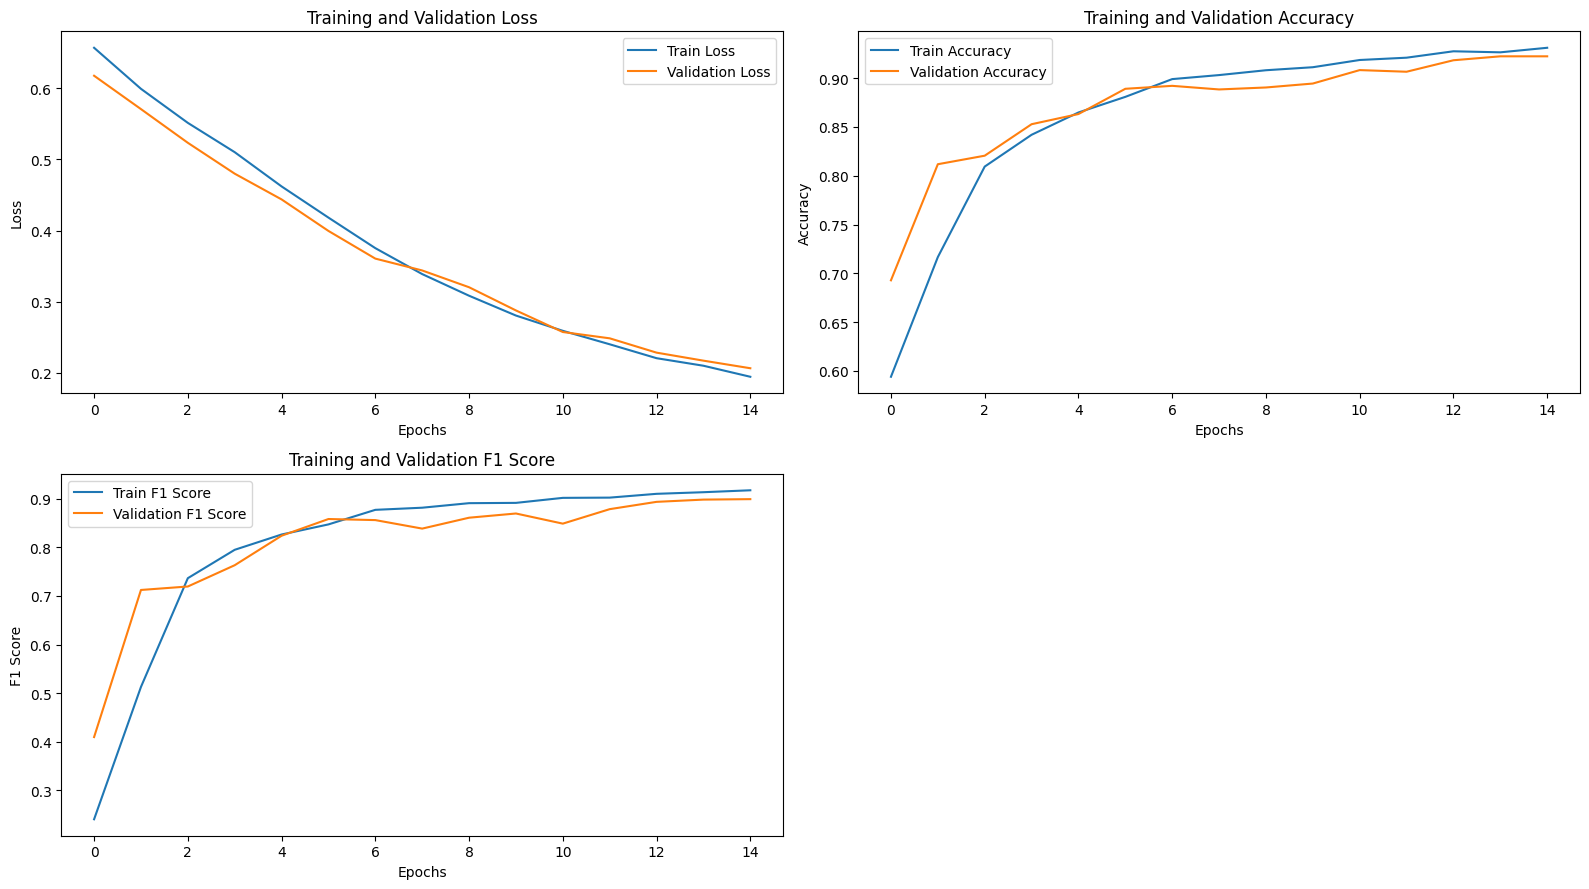

In [28]:
plot_training_history(train_loss_history, train_acc_history, train_f1_history,
                      valid_loss_history, valid_acc_history, valid_f1_history)

In [29]:
# 모델 로드 함수 정의
def load_model(model_path, model_checkpoint):
    model = OneWayBERTwithYouTube(model_checkpoint)
    model.load_state_dict(torch.load(model_path))
    model.to(device)
    return model

# Inference 함수 정의
def inference(model, test_dataloader, device):
    model.eval()

    preds_list = []
    true_labels = []

    with torch.no_grad():
        for batch in tqdm(test_dataloader, desc='Testing'):
            input_ids, attention_mask, labels = batch
            input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)

            outputs = model(input_ids, attention_mask)
            preds = torch.argmax(outputs, dim=1)

            preds_list.extend(preds.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())

    return preds_list, true_labels

In [30]:
# 저장된 모델 경로
best_model_path = path+'/models/Youtube/RoBERTaWithYouTube(Total)_ACC_0.9224.pth'
print(best_model_path)

/content/drive/MyDrive/Projects/Model/models/Youtube/RoBERTaWithYouTube(Total)_ACC_0.9224.pth


In [31]:
# 모델 불러오기
model = load_model(best_model_path, model_checkpoint)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at klue/roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [32]:
preds_list, true_labels = inference(model, test_dataloader, device)

Testing: 100%|██████████| 31/31 [00:16<00:00,  1.90it/s]


In [33]:
# 평가 지표 계산
test_accuracy = accuracy_score(true_labels, preds_list)
test_f1 = f1_score(true_labels, preds_list)

print(f'Test Accuracy: {test_accuracy:.4f}')
print(f'Test F1 Score: {test_f1:.4f}')

Test Accuracy: 0.9388
Test F1 Score: 0.9297


### 7. 개선점 및 To do

1. ```max_length```를 128로 설정했을 때 확실히 학습이 오래 걸린다. 64로 설정하면 어떻게 달라질까?
2. 믿을 수 있는 유튜버들의 영상을 더 많이 수집해서 클래스 차이가 벌어지도록 하자. 그러고 F1 Score가 얼마나 잘 나오는지 확인해보자.
3. Accuracy, F1 Score 이에외도 사용할 수 있는 평가지표를 찾아보자.
4. 조기종료 발동 조건 근처에도 가지 않았다. 검증 Loss는 계속 줄어드는 추이기 때문에 ```num_epochs```를 더 늘려보자. 물론 A100이 필요할 것 같다.
5. 비슷한 맥락에서 ```learning rate```를 조금만 더 크게 해보자. 지금도 학습이 잘 되고는 있는데 빠르게 개선하는 것이 의미 있을지 확인해보면 좋을 것 같다.
6. ⭐️ 썸네일 링크가 있다. 썸네일을 다운 받아서 Early Fusion 방식의 Multimodal도 아키텍쳐를 구상해보자.
7. New 데이터에 대한 Inference가 얼마나 걸리는지 확인해보자. 출력값은 ```logits```이기 때문에 별다른 활성화함수 없이도 확률을 출력할 수 있을 것이다.
8. 애매한 데이터도 추가해보자. 확실한 데이터는 사람이 봐도 분류할 수 있지만, 서비스 차원에서 많은 사람들이 아무 영상이나 입력할 수 있다. 그러면 Out-of-Data 이슈 때문에 제대로 판단할 수 없을 것이다. -> 게임, 뷰티, 먹방 등을 추가해보자.
9. 쇼츠 영상은 아직 레이블에 따라서 수집하지는 못했다. 이미 수집되어 있는건지는 모르겠지만, 쇼츠도 더 수집해서 학습시키자.